# Week 3 Peer Review for DTSA 5511

## Problem Description and Data Overview

For this project, I am going to use an image library of pathologic scans to identify if a scan shows that the individual has metastatic cancer or not. This is useful to know because it can allow for better/earlier detection of cancer and could possibly save lives. The data comes pre-divided into test and training folders with each file in the folder being one scan. The train folder also includes a .csv file that contains the labels (0 or 1) for each training image that will be used to identify the training image labels.

From the kaggle dataset description: "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

## Exploratory Data Analysis

#### For my EDA procedure, I will try to answer the following:
1. how many positive cases of cancer do we have in the training data?
2. what proportion of positive vs negative cases do we have in the training data?
3. what are some example images of positive cancer cases?
4. what are some example images of negative cancer cases?

Answering these questions will allow me to better define my neural network layers so that they can hopefully identify the cancer images more accurately and efficiently.

#### Data Cleaning
For data cleaning, I will check to see if there are any duplicates in the data (the kaggle description made it seem like this may be a possiblity), and see if there are any blanks within the data. From there, I will decide what data cleaning measures to make.

In [2]:
# Perform library imports
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from PIL import ImageDraw

import keras
train_on_gpu = True

2024-04-21 19:43:09.639444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 19:43:09.639574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 19:43:09.905274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
px.histogram(labels['label'], title= "Histogram of Cancer Images")

From this breakdown, I can answer my first 2 questions. There are 130,908 negative cancer images and 89,117 positive cancer images. This means that the proportion of positive cancer images is 40.5% and proportion of negative images is 59.5%.

In [5]:
# Now I need to load in the image files
train = "/kaggle/input/histopathologic-cancer-detection/train/"
test = "/kaggle/input/histopathologic-cancer-detection/test"

img_train = os.listdir(train)
img_test = os.listdir(test)

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


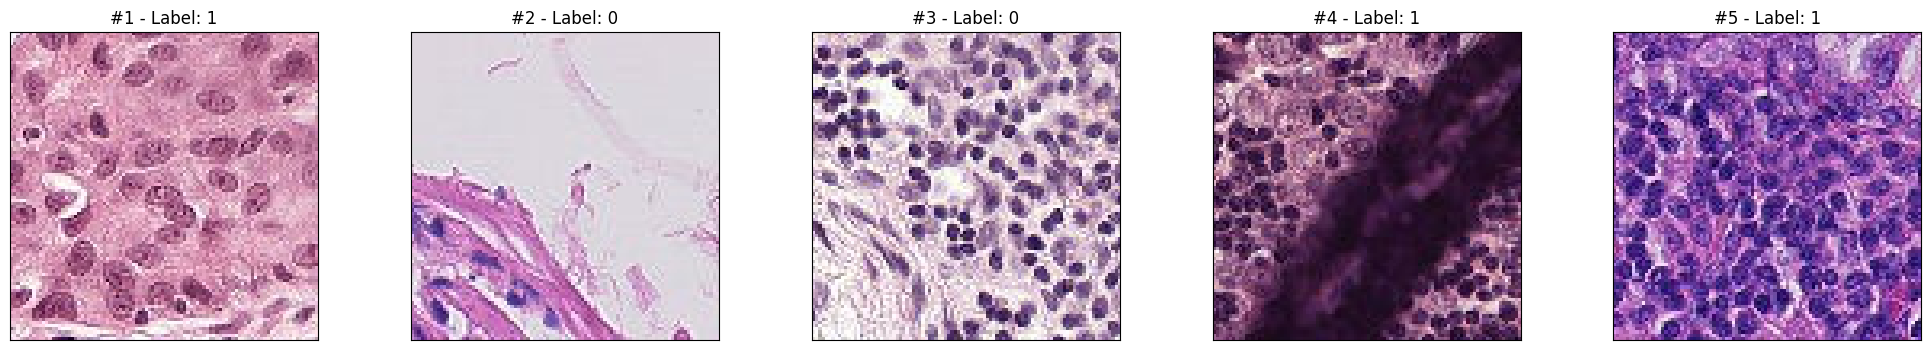

In [6]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = labels.loc[labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

Here we can see from the images above, that the 1st, 4th, and 5th images show cancer, while the 2nd and 3rd do not. This provides the context for the 3rd and 4th questions I had above.

In [7]:
# Data cleaning
# check for duplicates
dc_temp = labels[labels.duplicated(subset='id')]

print('count of duplicates: ',len(dc_temp))
# check for blank id's
dc_temp = sum(labels.id.isna())

print('count of blank ids: ', dc_temp)
#check for blank labels
sum(labels.label.isna())

print('count of blank labels: ', dc_temp)

count of duplicates:  0
count of blank ids:  0
count of blank labels:  0


It looks like we have all of our data intact with no duplicates. Based on the provided data description in kaggle, this makes sense. This dataset came precleaned and ready to work with, so I will not preform any additional data cleaning procedures.

## Model Architecture
### Description
Two models that I can try are CNN's and Transfer Learning models. 
#### CNN Model
A CNN model built on an architecture like ResNet would be good for this project because these models are built on heirarchical methods of clustering data, so they are very good at identifying high level trends. Since this is a binary classification problem, having the high-level trends identified would help quickly sort through a significant amount test data.

CNNs are also equipted to handle local connectivity which means that they are able to identify a pattern (in this case cancer) in various local areas of the image rather than being tied to only one area of the image.

#### Transfer Leaning Model
Transfer learning can be an effective model because it utilizes a model(s) that has already been trained for this type of problem using other images. Since we have been given a very large training dataset (recall that the training folder contained 220025 labeled images), we can use a pretrained model to assist in training this model.

Utilizing a pretrained model for transfer learning can also be very effective at reducing the computational needs of the computers for pretraining. Identifying the early parameters that need to be used and hyperparameter tuning is very computationally expensive. Transfer learning models do not require you to spend as much time and resources on this step which can be very time saving.

In [5]:
import tensorflow as tf

# tf.config.experimental.set_visible_devices('/GPU: P100')
# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
samples = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [7]:
train_data, val_data = train_test_split(labels, test_size=0.2, random_state=21, stratify=labels['label'])
train_data = train_data.astype(str)
val_data = val_data.astype(str)
val_data

,id,label
38467,48818ad9393decc3513e97eafcf8a4596f46d731,1
6847,7d9cd51424d52e7856cf13c1567a46ad405d0076,0
73116,9f824a9a43c30b2d607e240419f8b49f0e2acd4f,1
88553,a9b34d54cf21c4db8917f1b1999720f28c139381,1
56697,bdc442392417f27469bbae45ec3efbe88adf3e38,0
...,...,...
74451,28a911b41fca6aa6bcb3512719051fc1e22e8fbc,1
197028,01b84c634fd12ffce8ae8809216acd0cd877a800,0
111923,6b5e1c8e929dcaeea54d2c594328c9084c9b2c7d,1
72550,3225bbb536854ae0cf8b150168f555a0ed3f692c,1


In [10]:
# img_train

In [ ]:
from tqdm import tqdm
Path = '/kaggle/input/histopathologic-cancer-detection/'
train_df = pd.read_csv(Path + 'train_labels.csv')
def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(Path + f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)
def convert_image_wrapper(args):
    return convert_image(*args)

def process_images(image_files, labels=[], with_label=True, subset='train'):
    tasks = [(filename, labels[index] if with_label else 0, with_label, subset) for index, filename in enumerate(image_files)]
    for task in tqdm(tasks):
        convert_image_wrapper(task)
process_images((train_df['id']+'.tif').values.tolist(), labels=train_df['label'].values.tolist())
process_images(os.listdir(Path+"test"), with_label=False, subset='test')

 89%|████████▉ | 51361/57458 [11:26<01:31, 66.41it/s]

In [15]:
train_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            batch_size=128)

val_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=128)
# Reading the test dataset:
test_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/test',
                                                            label_mode=None,
                                                            image_size=(96,96),
                                                            shuffle=False,
                                                            batch_size=1)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.
Found 57458 files.


In [17]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,473 (458.88 KB)

 Trainable params: 117,473 (458.88 KB)

 Non-trainable params: 0 (0.00 B)

### Table/Figure of my model
The above table shows a breakdown of what my neural network looks like from a high level view. As we can see there are a significant amount of parameters (a total of 900kb in file names) that will have to be flowed through 10 layers.

In [18]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(train_dataset, epochs=4, validation_data=val_dataset)

Epoch 1/4
   4/1376 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - accuracy: 0.5337 - loss: 0.6805

I0000 00:00:1713721005.435931      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713721005.456796      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7549 - loss: 0.4978

W0000 00:00:1713721076.182228      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713721077.287455      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 94s 64ms/step - accuracy: 0.7549 - loss: 0.4977 - val_accuracy: 0.8246 - val_loss: 0.3952
Epoch 2/4


W0000 00:00:1713721093.698424      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 78s 56ms/step - accuracy: 0.8305 - loss: 0.3816 - val_accuracy: 0.8420 - val_loss: 0.3663
Epoch 3/4
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 68s 49ms/step - accuracy: 0.8547 - loss: 0.3348 - val_accuracy: 0.8652 - val_loss: 0.3195
Epoch 4/4
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accuracy: 0.8713 - loss: 0.3050 - val_accuracy: 0.8701 - val_loss: 0.3087


In [20]:
test_imgs = os.listdir("/kaggle/working/png/test")
sub_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)

In [21]:
predictions = model.predict(test_dataset)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step


In [22]:
sub_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
sub_pred_df['label'] = np.round(predictions.flatten()).astype('int')
sub_pred_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [24]:
SAMPLE_SUB = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)
pred_dict = dict((key, value) for (key, value) in zip(sub_pred_df.id, sub_pred_df.label))
pred_corr = [pred_dict[id] for id in sample_list]
submission_df = pd.DataFrame({"id": sample_list, "label": pred_corr})
submission_df.to_csv("submission.csv", header=True, index=False)

## Results and Analysis
### Hyperparameter Testing and Tuning Discussion
While training my model I tested out a couple of different hyperparameters including MaxPooling and Conv2d. I used maxpooling because when looking at the sample photos of the training set, I saw that there was a lot of dark areas on the malignant tumors. Using the maxpooling method would help to pull out and amplify these parts of the photographs. On the benign case photos, there were not as strong of dark lines and areas in the scans. This means that the darker areas would get to stand out more as the images move through the network and get classified. 

I used Conv2d because I knew it would be quicker for the network to make classifications if I flattened the images as much as possible. I/the computer also only needed to see 2d images to identify features that would be indicative of a tumor. By implementing many layers of Conv2d, I was able to compress the number of pixels that need to be analyzed as the photo move through the network. This would not lead to a significant amount of data integrity loss because I had already done the maxpooling layers. These layers also helped to "slim down" the data and only keep the most important features for analysis.

### How I improved Performance over Iterations
Improvement in performance came from playing around with batch size and epoch number.  I was only able to test a few different combinations because the GPU on kaggle is super limited and still takes hours to run each iteration test and the note in the instructions was that we were not expected to spend an intense amount of time testing all different parameter tuning methods. In the end I found that a batch size of 128 was good for grabbing a good sampling of images that lead to the best accuracy from the iterations that I tested. I also found that 4 epochs was best due to both runtime and due to the fact that the accuracy started to even out by epochs 3 and 4. This evening out means that there was a risk of the model becoming overfit if I tried to do too many more epoch sizes.

## Conclusions
### Actual Results
In the end, my model was able to acheive an accuracy of 87.13% with a loss of 0.3.

This accuracy score means that the model is able to take the test data images and accurately identify a cancerous tutor ~87% of the time. The results of my and other models on this dataset should be taken with a grain of salt because the implications of false positives and false negtaives can be very tramatic. If someone gets a false positive and a doctor does not go in and manually verify the scans, then this can cause a lot of stress and anxiety in a patient and in their families. A false negative is probably more detrimental because a trained doctor is less likely to go in and verify that the scan does not show a cancerous tumor. It also gives a false sense of security and they may not be able to act in a way that shrinks/improves the outcomes for the patient.
### What went well vs what did not
I think that the accuracy I was able to get with the limited hardware capabilities of the kaggle kernal was pretty good. Unfortunately, even though I was able to tell the notebook to use the GPU T4x2, there was no improvement in notebook runtime. This greatly decreased the amount of testing that I would have liked to have done for the hyperparameters. If I had a better GPU, then I would have liked to tested different loss functions so that I could improve the accuracy even more.
